# Recommendation System For Top 5 Movies

## Team 4 - Phase Four Project

### Authors:
1. Hellen Muanki
2. Jesicah Mutiso
3. Endalkachew Dessalegne
4. Brian Waweru
   

## 1. Project Overview

A new movie streaming startup, aims to offer a highly personalized viewing experience to differentiate itself in a crowded market. One of its core features is a movie recommendation system that helps users discover films they are likely to enjoy, based on their past preferences.

Accurate and relevant movie recommendations to users based on factors such as movie ratings and rating counts.



## 1.1. Business Understanding 
### 1.1.1 Business Problem 


### 1.1.2. Key Business Questions

1. What top 5 movies can be recommeded for a user with ratings for other movies?
2. what top 5 movies can be recommended for a new user with no ratings of movies?

## 2. Data Understanding

In [58]:
#import necessary libraries 

import pandas as pd
import numpy as np
from surprise import Dataset, Reader, SVD
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity 
from surprise.model_selection import train_test_split as surprise_split 
from sklearn.model_selection import train_test_split
from surprise import accuracy
import matplotlib.pyplot as plt
import seaborn as sns



In [59]:
# load movies dataset
df_movies = pd.read_csv("data/movies.csv")
df_movies.head(5)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [60]:
#load ratings dataset
df_ratings = pd.read_csv("data/ratings.csv") 
df_ratings.head(5)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [61]:
#shape of df_movies
df_movies.shape

(9742, 3)

In [62]:
#shape of df_ratings
df_ratings.shape

(100836, 4)

In [63]:
df_ratings.userId.value_counts(sort=False)

64     517
128     33
192     22
256    174
320     20
      ... 
319     35
383     34
447     78
511     52
575     36
Name: userId, Length: 610, dtype: int64

In [64]:
#merge movies and ratings dataset
df = df_ratings.merge(df_movies, on="movieId")
df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [65]:
df.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


In [66]:
print(f"Mode of rating: {df.rating.mode()}")
print(f"Mean of rating: {df.rating.mean()}")
print(f"Median of rating: {df.rating.median()}")

Mode of rating: 0    4.0
dtype: float64
Mean of rating: 3.501556983616962
Median of rating: 3.5


In [67]:
#check datatypes and null values 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100836 entries, 0 to 100835
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
 4   title      100836 non-null  object 
 5   genres     100836 non-null  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 5.4+ MB


In [68]:
#check datatypes and null values 
df.duplicated().sum()

0

## 3. Exploratory Data Analysis

### Nmber of Movies, Ratings and Users

* Number of movies, ratings and users in the datasets
* Average number of ratings per user
* Average number of ratings per movie

In [69]:
#number of ratings of movies 
n_ratings = len(df_ratings) 
# number of movies 
n_movies = df_ratings['movieId'].nunique()
# number of users 
n_users = df_ratings['userId'].nunique() 

print(f"Number of ratings: {n_ratings}")
print(f"Number of movies: {n_movies}") 
print(f"Number of users: {n_users}") 
print()
# Average number of ratings per user & per movie
print(f"Average number of ratings per user: {round(n_ratings/n_users, 2)}") 
print(f"Average number of ratings per movie: {round(n_ratings/n_movies, 2)}")

Number of ratings: 100836
Number of movies: 9724
Number of users: 610

Average number of ratings per user: 165.3
Average number of ratings per movie: 10.37


### Distribusion of movie ratings

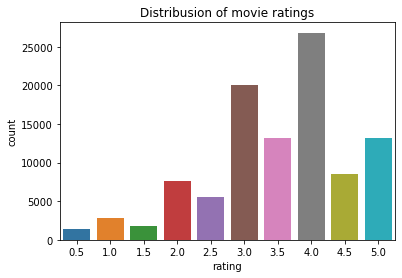

In [70]:
# plot bar graph to show distribution of movie ratings
sns.countplot(x='rating', data=df_ratings) 
plt.title("Distribusion of movie ratings")
plt.show()

In [71]:
print(f"Mean of ratings: {round(df_ratings['rating'].mean(), 2)}")

Mean of ratings: 3.5


### Movies most frequently rated

In [72]:
# most frequently rated movies in the dataset
top_movie_ratings = df['title'].value_counts()[0:5] 
top_movie_ratings

Forrest Gump (1994)                 329
Shawshank Redemption, The (1994)    317
Pulp Fiction (1994)                 307
Silence of the Lambs, The (1991)    279
Matrix, The (1999)                  278
Name: title, dtype: int64

## 4.  Modeling 

### 4.1. Model for Collaborative Filtering 
* Recommend movies using collaborative filtering
* This model recommends movies for a user based on user ratings of other movies and other similar uers' ratings

In [73]:
# Prepare dataset for Surprise
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(df_ratings[['userId', 'movieId', 'rating']], reader)
#trainset = data.build_full_trainset() 

In [74]:
#Random Split of the dataset to trainset and testset 
trainset, testset = surprise_split(data, test_size=0.2)

# Train SVD model
svd_model = SVD()
svd_model.fit(trainset)

### Recommendation of top 5 movies for a user

In [75]:
# function for recommendation of top 5 movies for a user using the trained model

def get_cf_recommendations(userId, num_recommendations=5):
    #predict ratings by a user for movies
    predictions = [svd_model.predict(userId, movieId).est for movieId in df_movies["movieId"]]
    df_movies["predicted_rating"] = predictions
    recommendations = df_movies.sort_values("predicted_rating", ascending=False).head(num_recommendations)
    return recommendations[["title", "genres"]]
 
# print recommended movies for a user as an example of model usage
print(get_cf_recommendations(userId=10))

                                               title  \
7466                       King's Speech, The (2010)   
46                        Usual Suspects, The (1995)   
4025  Grave of the Fireflies (Hotaru no haka) (1988)   
685                                   Vertigo (1958)   
975                            Cool Hand Luke (1967)   

                              genres  
7466                           Drama  
46            Crime|Mystery|Thriller  
4025             Animation|Drama|War  
685   Drama|Mystery|Romance|Thriller  
975                            Drama  


* Above is a recommendation of top 5 movies for userId = 10, as an example

## Evaluation of the Model on testset

* **Performance metric** Root Mean Square Error **(RMSE)** is used to evaluate the accuracy of the model
* It evaluates the model's predicted ratings versus the actual ratings in the test set

In [76]:
# Predict on testset
predictions_test = svd_model.test(testset) 

for pred in predictions_test[:3]: 
    print(pred)

print("RMSE:", accuracy.rmse(predictions_test))

user: 111        item: 39         r_ui = 4.00   est = 3.17   {'was_impossible': False}
user: 373        item: 357        r_ui = 3.00   est = 3.55   {'was_impossible': False}
user: 63         item: 59615      r_ui = 4.00   est = 2.70   {'was_impossible': False}
RMSE: 0.8741
RMSE: 0.8741260837327777


* svd_model prediction object include: **user ID**, the **item (movie) ID**, **r_ui**(the true rating if known (otherwise None)), **est**(the model's estimated rating) and details: any additional metadata (like confidence)

* A value of 0.87 of **RMSE** shows that the model deviated by about 0.87 ratings 
from the actual ratings on a 0.5 - 5.0 ratings
* It is below 1.0 and can be considered good model performance

### 4.2. Model for Content-Based Filtering

* To recommend similar movies for a new user based on the genre of a movie watched 
* This model adresses **cold start**, when user has not rated movies yet

In [77]:
# for this we use the merged df
# we split the dataset into train/test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [78]:
# We build the TF-IDF using only the train set
# Convert the genres into TF-IDF features

tfidf = TfidfVectorizer(stop_words="english")
tfidf_matrix = tfidf.fit_transform(train_df["genres"]) 

# Store movie indices
movie_indices = pd.Series(train_df.drop_duplicates("movieId").index,
                          index=train_df.drop_duplicates("movieId")["title"]).drop_duplicates()

In [79]:
#define a function that takes in a movie title as an input to return 5 similar movies
def get_cbf_recommendations(title, num_recommendations=5):
    
    # map movie title to its row index
    idx = movie_indices[title] 
    
    # plug idx into similarity matrix
    # Cosine similarity measures how similar two vectors are
    #Calculate scores between the TF-IDF vectorof chosen movie (tfidf_matrix[idx]) 
    #and all other movies in the matrix.
    sim_scores = list(enumerate(cosine_similarity(tfidf_matrix[idx], tfidf_matrix)[0]))
    
    #sort the similarity scores in descending order (most similar first).
    #skip index 0(that's the movie itself) and take the next best matches.
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:num_recommendations+1]
    
    # extract the row indices of those top similar movies
    movie_ids = [i[0] for i in sim_scores]
    
    #return the title and genre of the top similar movies
    return df_movies.iloc[movie_ids][["title", "genres"]]
# Example Usage
print(get_cbf_recommendations("Toy Story (1995)"))

                               title               genres
33           Dead Man Walking (1995)          Crime|Drama
36   Cry, the Beloved Country (1995)                Drama
128            Beyond Rangoon (1995)  Adventure|Drama|War
160                  Reckless (1995)       Comedy|Fantasy
236          Man of the House (1995)               Comedy


### 5. Conclusions 
* We implemented Collaborative Filtering(CF) using SVD from the Suprise library
* Evaluation matrix RMSE = 0.87 for Collaborative Filtering is achieved. This is acceptable for rating prediction.
* Collaborative Filtering is ideal for personalized recommendations once the user has rated many items/movies.
* We used TF-IDf vectorization of genre for Content-Based Filtering(CBF) to recommend top N unseen movies to especially for new users or items not yet rated.
 

### 6. Recommendations 
* Use hybrid system(Combine CF and CBF) for better accuracy
* Hyperparameter tuning for CF to improve RMSE
* To include more features such as movie description for CBF to improve the model. 